In [1]:
# Import tensorflow and check it is using GPU to run
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Import other modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from sklearn.metrics.pairwise import euclidean_distances

In [3]:
# Retrieve CIFAR Fashion dataset available from tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

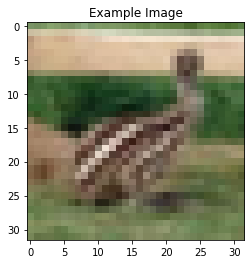

In [7]:
# Visualise image
i = np.random.choice(len(x_train))
plt.imshow(x_train[i], cmap='viridis')
plt.title("Example Image");

In [8]:
# Normalize the input features to get values between 0 and 1 for the colour channels
x_train, x_test = x_train/255, x_test/255

In [9]:
# Input requires us to provide the shape which is the H X W X C without the number of samples N.
print(x_train[0].shape)
i = Input(shape=x_train[0].shape)

(32, 32, 3)


In [10]:
# Define ResNet block
def resnet_block(input_tensor, filters, kernel_size=(3, 3), strides=(1, 1)):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Adjust the shortcut connection
    if strides != (1, 1) or input_tensor.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same')(input_tensor)
    else:
        shortcut = input_tensor
    
    x = Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [11]:
# Define the model architecture
inputs = Input(shape=x_train[0].shape)

In [12]:
# Encoder
x = resnet_block(inputs, 32)
x = resnet_block(x, 64)
encoded = resnet_block(x, 128, strides=(2, 2))

# Decoder
x = UpSampling2D((2, 2))(encoded)
x = resnet_block(x, 64)
x = UpSampling2D((1, 1))(x)
x = resnet_block(x, 32)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [15]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 32)   0           ['batch_normalization[0][0]']

In [14]:
# Compile the autoencoder
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

In [18]:
# Train the model 
history = autoencoder.fit(x_train, x_train, epochs=10, validation_data=(x_test, x_test))

Epoch 1/10
1563/1563 [==============================] - 150s 96ms/step - loss: 9.6912e-04 - val_loss: 6.8186e-04
Epoch 2/10
1563/1563 [==============================] - 148s 95ms/step - loss: 6.9102e-04 - val_loss: 4.6037e-04
Epoch 3/10
1563/1563 [==============================] - 148s 95ms/step - loss: 4.8664e-04 - val_loss: 4.1018e-04
Epoch 4/10
1563/1563 [==============================] - 148s 95ms/step - loss: 3.3407e-04 - val_loss: 2.3929e-04
Epoch 5/10
1563/1563 [==============================] - 148s 95ms/step - loss: 2.7082e-04 - val_loss: 2.1680e-04
Epoch 6/10
1563/1563 [==============================] - 148s 95ms/step - loss: 2.3240e-04 - val_loss: 2.1373e-04
Epoch 7/10
1563/1563 [==============================] - 148s 94ms/step - loss: 1.9602e-04 - val_loss: 1.1389e-04
Epoch 8/10
1563/1563 [==============================] - 147s 94ms/step - loss: 1.6905e-04 - val_loss: 1.2248e-04
Epoch 9/10
1563/1563 [==============================] - 147s 94ms/step - loss: 1.5706e-04 - val_

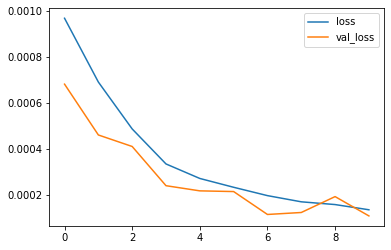

In [19]:
# Plot loss per iteration

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

# For increasing validation loss, it is a sign we are overfitting and can be reduced by normalization.

In [21]:
# Save this model
autoencoder.save('ResNet_CIFAR_Autoencoder.keras')

In [16]:
# Load the model
autoencoder = load_model('ResNet_CIFAR_Autoencoder.keras')

In [22]:
# Compile the model
autoencoder.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

In [13]:
# Save the history object 
# Convert the history.history dict to a pandas DataFrame
hist_df = pd.DataFrame(history.history)

# Save to csv
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Save to pickle
with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

NameError: name 'history' is not defined

In [17]:
# Generate Encoded Representations for the testing database

# encoder = Model(inputs=autoencoder.input, outputs=encoded)
encoded_database = autoencoder.predict(x_train[:20000])

625/625 [==============================] - 23s 26ms/step


In [28]:
# Provide a test image for similarity check
i = np.random.choice(len(x_test))
input_image = x_test[12:13]

In [29]:
input_image.shape

(1, 32, 32, 3)

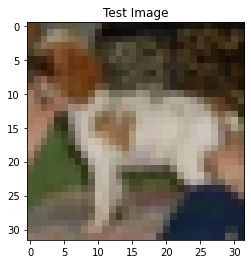

In [30]:
# Visualise test image
plt.imshow(input_image[0], cmap='viridis')
plt.title("Test Image");

In [31]:
input_image_encoded = autoencoder.predict(input_image)

1/1 [==============================] - 0s 37ms/step


In [32]:
print("Input image encoded shape", input_image_encoded.shape)
print("Encoded database shape", encoded_database.shape)

Input image encoded shape (1, 32, 32, 3)
Encoded database shape (20000, 32, 32, 3)


In [33]:
# Reshaping to allow calculating of euclidean distances
input_image_encoded_flat = input_image_encoded.reshape(1,-1)
encoded_database_flat = encoded_database.reshape(encoded_database.shape[0], -1)

print("Input image encoded flat shape:", input_image_encoded_flat.shape)
print("Encoded flat shape:", encoded_database_flat.shape)

Input image encoded flat shape: (1, 3072)
Encoded flat shape: (20000, 3072)


In [34]:
# Calculate similarities and find the most similar day:

# Use <Euclidean distances> to calculate the Euclidean distances between the input day's encoded representation and the encoded representations of all the days in the database.

# Calculate Euclidean distances 
distances = euclidean_distances(input_image_encoded_flat, encoded_database_flat)

# Find the index of the most similar day (smallest distance)
most_similar_image_index = np.argmin(distances)

In [35]:
print(most_similar_image_index)

8398


In [36]:
# Retrieve the data of the most similar day
most_similar_image_data = x_train[most_similar_image_index]

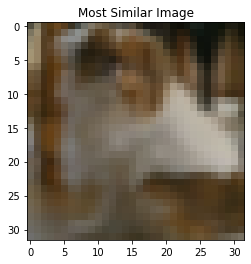

In [37]:
# Visualise most similar database image
plt.imshow(most_similar_image_data, cmap='viridis')
plt.title("Most Similar Image");